In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

sns.set_style("whitegrid")

def load_and_analyze_data(file_path):
    df = pd.read_csv(file_path, index_col=0)
    print(f"There are {df.shape[0]} observations for {df.shape[1]} predictors.")

    missing_values = df.isnull().sum()
    description = df.describe(include='all')

    return df, missing_values, description

file_path = "C:/Users/srina/Documents/Big Data science/Dataset_project/clean_Dataset.csv"

dataframe, missing_values, description = load_and_analyze_data(file_path)

print(dataframe.head())
print(missing_values)
print(description)


There are 300153 observations for 11 predictors.
    airline   flight source_city departure_time stops   arrival_time  \
0  SpiceJet  SG-8709       Delhi        Evening  zero          Night   
1  SpiceJet  SG-8157       Delhi  Early_Morning  zero        Morning   
2   AirAsia   I5-764       Delhi  Early_Morning  zero  Early_Morning   
3   Vistara   UK-995       Delhi        Morning  zero      Afternoon   
4   Vistara   UK-963       Delhi        Morning  zero        Morning   

  destination_city    class  duration  days_left  price  
0           Mumbai  Economy      2.17          1   5953  
1           Mumbai  Economy      2.33          1   5953  
2           Mumbai  Economy      2.17          1   5956  
3           Mumbai  Economy      2.25          1   5955  
4           Mumbai  Economy      2.33          1   5955  
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class           

C:\Users\srina\AppData\Local\Temp\ipykernel_10408\2420337190.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='price', shade=True)


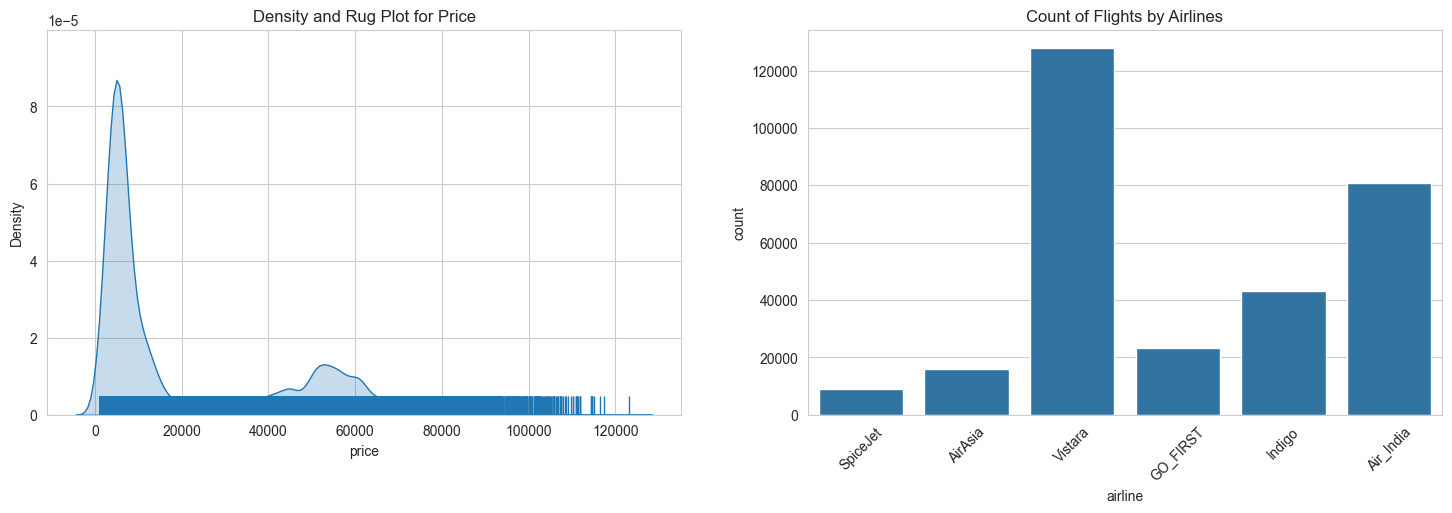

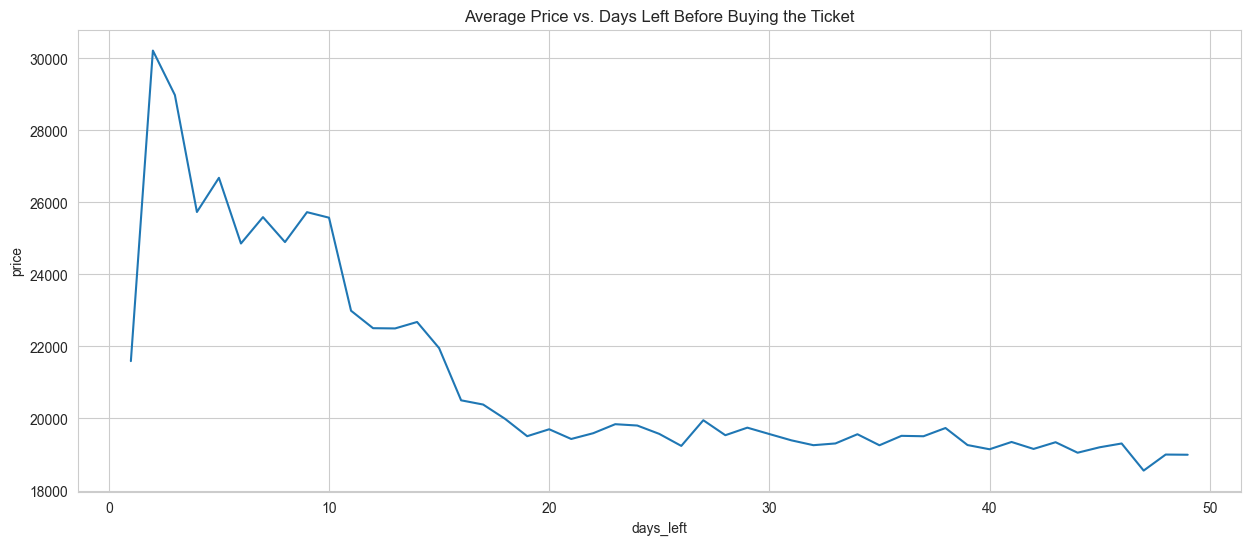

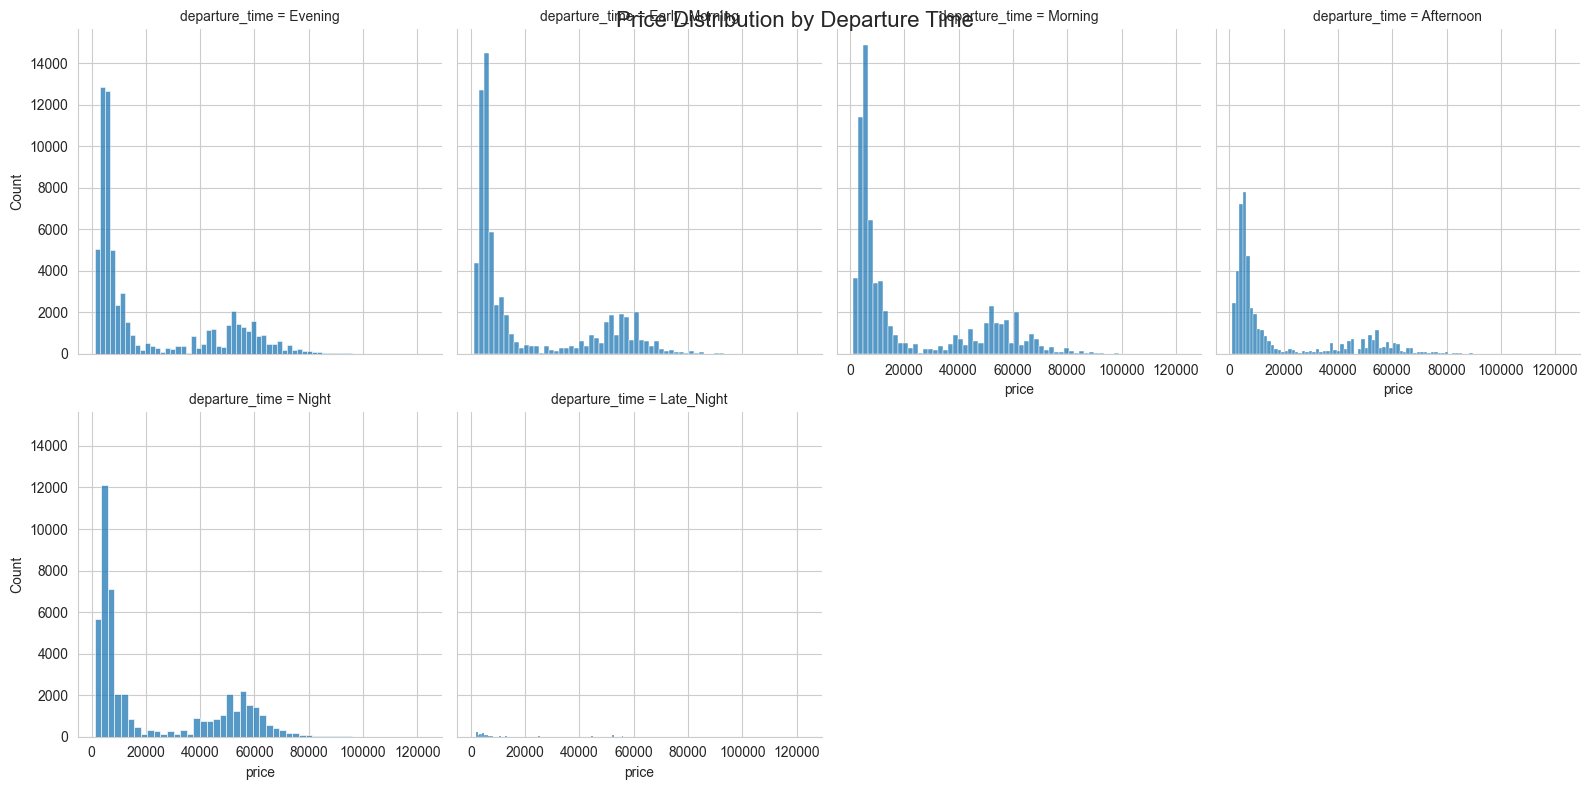

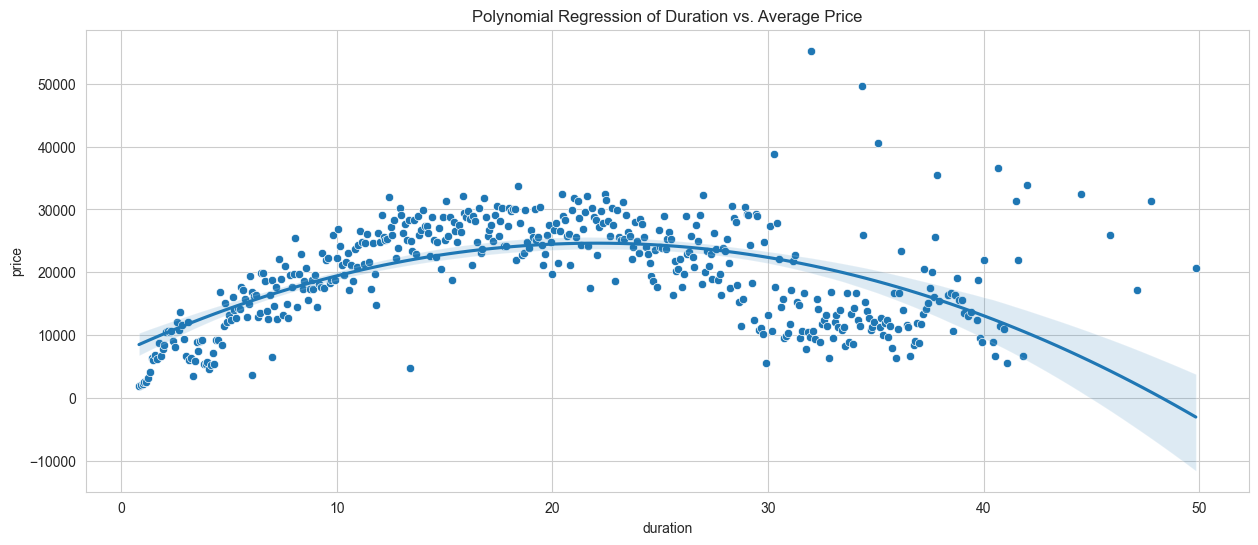

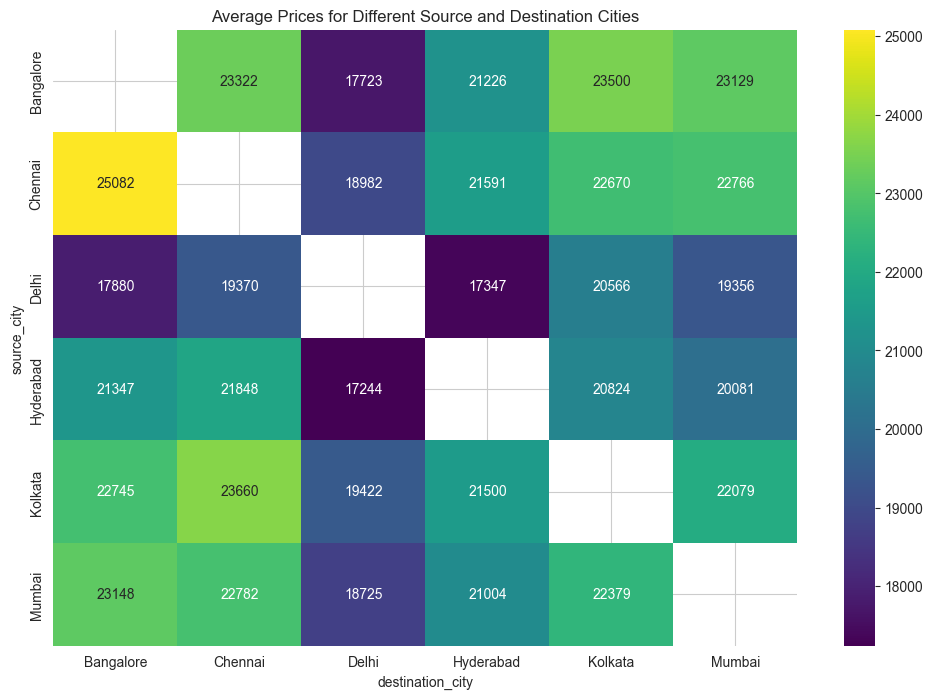

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_visualizations(df):

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 2, 1)
    sns.kdeplot(data=df, x='price', shade=True)
    sns.rugplot(data=df, x='price', height=0.05)
    plt.title('Density and Rug Plot for Price')

    plt.subplot(1, 2, 2)
    sns.countplot(data=df, x='airline')
    plt.xticks(rotation=45)
    plt.title('Count of Flights by Airlines')
    plt.show()

    avg_price_days = df.groupby('days_left')['price'].mean().reset_index()
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=avg_price_days, x='days_left', y='price')
    plt.title('Average Price vs. Days Left Before Buying the Ticket')
    plt.show()

    g = sns.FacetGrid(df, col='departure_time', col_wrap=4, height=4)
    g.map(sns.histplot, 'price', kde=False)
    g.fig.suptitle('Price Distribution by Departure Time', fontsize=16)
    plt.show()

    avg_price_duration = df.groupby('duration')['price'].mean().reset_index()
    plt.figure(figsize=(15, 6))
    sns.scatterplot(data=avg_price_duration, x='duration', y='price')
    sns.regplot(data=avg_price_duration, x='duration', y='price', scatter=False, order=2)
    plt.title('Polynomial Regression of Duration vs. Average Price')
    plt.show()

    pivot_table = df.pivot_table(values='price', index='source_city', columns='destination_city', aggfunc='mean')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='viridis')
    plt.title('Average Prices for Different Source and Destination Cities')
    plt.show()


plot_visualizations(dataframe)


Text(0.5, 1.0, 'Airline Prices Based on Arrival Time')

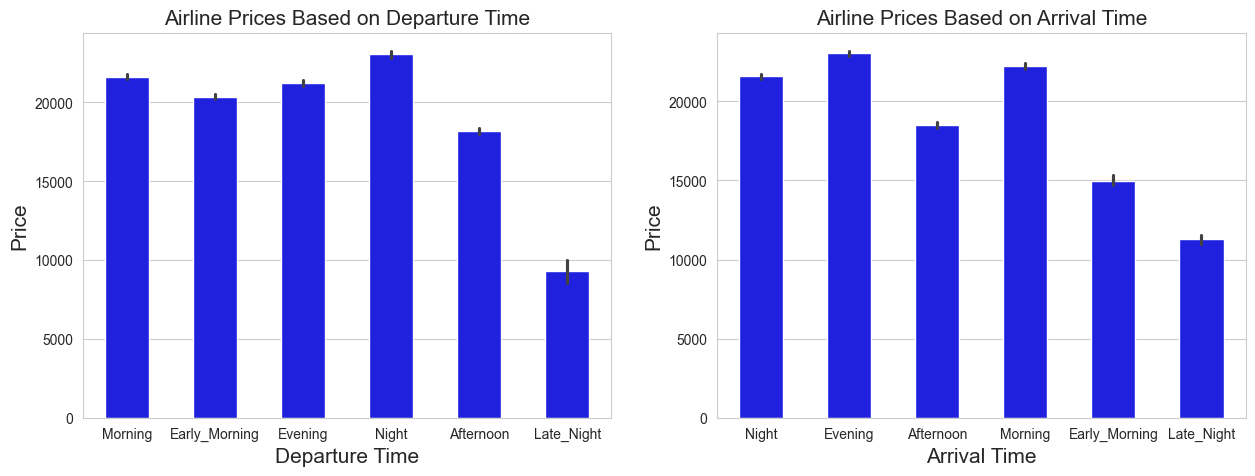

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sorted_data = df.sort_values("price", ascending=False)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
departure_time_plot = sns.barplot(y="price", x="departure_time", data=sorted_data, color='blue', width=0.5)
departure_time_plot.set_ylabel("Price", fontsize=15)
departure_time_plot.set_xlabel("Departure Time", fontsize=15)
departure_time_plot.set_title("Airline Prices Based on Departure Time", fontsize=15)

plt.subplot(1, 2, 2)
arrival_time_plot = sns.barplot(y="price", x="arrival_time", data=sorted_data, color='blue', width=0.5)
arrival_time_plot.set_ylabel("Price", fontsize=15)
arrival_time_plot.set_xlabel("Arrival Time", fontsize=15)
arrival_time_plot.set_title("Airline Prices Based on Arrival Time", fontsize=15)


Text(0.5, 1.0, 'Economy Class Airline Prices by Number of Stops')

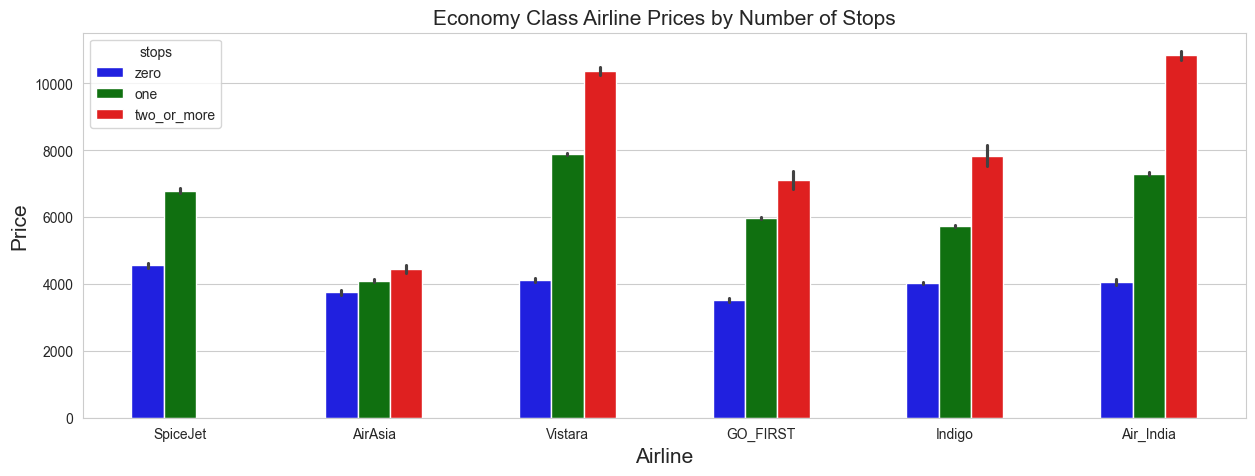

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

economy_class_flights = df[df["class"] == 'Economy']

plt.figure(figsize=(15, 5))
price_stops_plot = sns.barplot(x="airline", y="price", hue='stops', data=economy_class_flights, 
                               width=0.5, palette=["blue", "green", "red"])

price_stops_plot.set_ylabel("Price", fontsize=15)
price_stops_plot.set_xlabel("Airline", fontsize=15)
price_stops_plot.set_title("Economy Class Airline Prices by Number of Stops", fontsize=15)


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

def n_preprocessing(df):

    df["stops"] = df["stops"].replace({'zero': 0, 'one': 1, 'two_or_more': 2}).astype(int)
    df["class"] = df["class"].replace({'Economy': 0, 'Business': 1}).astype(int)
    
    label_variables = ["airline", "source_city", "destination_city", "departure_time", "arrival_time"]
    for col in label_variables:
        df[col] = LabelEncoder().fit_transform(df[col])

    df = df.drop(["flight"], axis=1)
    
    return df

df = pd.read_csv("C:/Users/srina/Documents/Big Data science/Dataset_project/clean_Dataset.csv", index_col=0)
df = n_preprocessing(df)

X = df.drop('price', axis=1)
y = df['price']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)



In [30]:
print(xtrain)

        airline  source_city  departure_time  stops  arrival_time  \
2406          5            2               5      1             4   
275865        5            3               4      1             2   
297156        5            1               1      1             2   
12826         5            2               2      1             5   
93166         2            0               4      1             5   
...         ...          ...             ...    ...           ...   
119879        5            4               2      1             0   
259178        5            0               5      1             5   
131932        1            4               5      1             4   
146867        2            4               0      1             5   
121958        1            4               0      1             4   

        destination_city  class  duration  days_left  
2406                   5      0     13.42         14  
275865                 2      1      9.58         23  
297156

In [31]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

models = {
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=50),
    "LinearRegression": LinearRegression(),
    "XGBRegressor": XGBRegressor(n_jobs=5, learning_rate=0.1, max_depth=10, random_state=1),
    "CatBoostRegressor": CatBoostRegressor(logging_level='Silent', iterations=500, random_state=1),
    "LGBMRegressor": LGBMRegressor(objective="regression", max_depth=10, n_estimators=2000, learning_rate=0.01, num_leaves=250)
}

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_and_evaluate(models, xtrain, ytrain, xtest, ytest):
    results = {}
    for name, model in models.items():
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)

        mse = mean_squared_error(ytest, preds)
        mae = mean_absolute_error(ytest, preds)
        r2 = r2_score(ytest, preds)
        results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    
    return results

evaluation_results = train_and_evaluate(models, xtrain, ytrain, xtest, ytest)
for model, metrics in evaluation_results.items():
    print(f"{model} - MSE: {metrics['MSE']}, MAE: {metrics['MAE']}, R2: {metrics['R2']}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 210107, number of used features: 9
[LightGBM] [Info] Start training from score 20895.951582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 210107, number of used features: 9
[LightGBM] [Info] Start training from score 20895.951582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

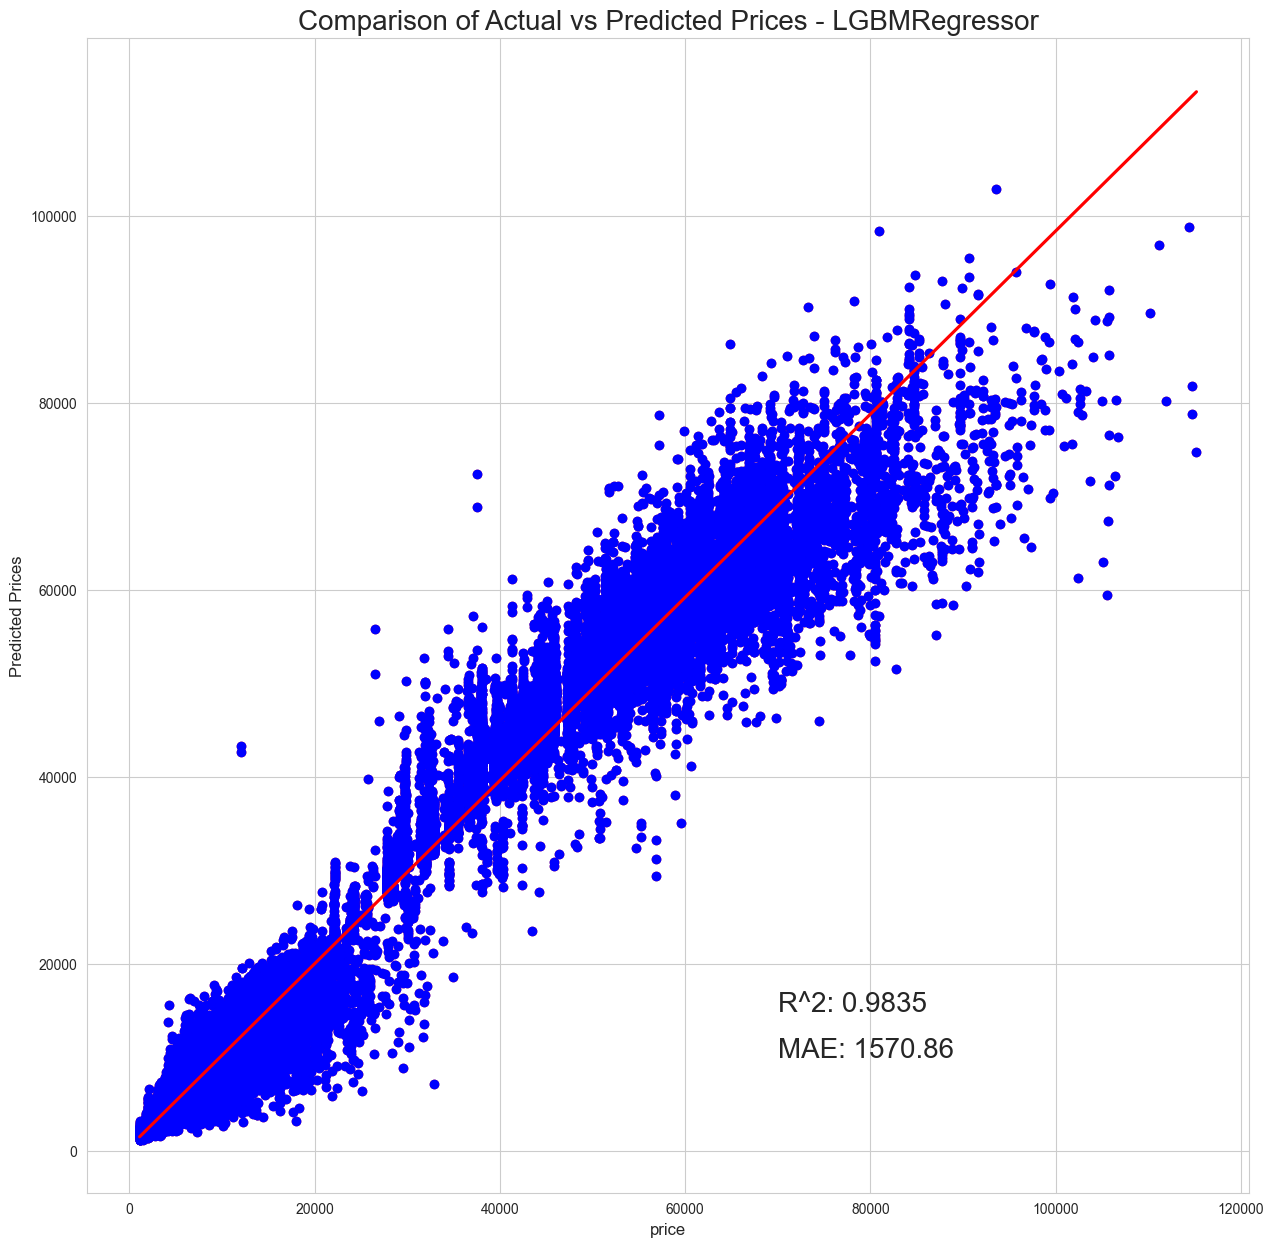

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error

lgbm_model = models["LGBMRegressor"]
lgbm_model.fit(xtrain, ytrain)

predictions = lgbm_model.predict(xtest)

plot_figure, axis = plt.subplots(figsize=(15, 15))
axis.set_title("Comparison of Actual vs Predicted Prices - LGBMRegressor", fontsize=20)
axis.set_xlabel('Actual Prices', fontsize=12)
axis.set_ylabel('Predicted Prices', fontsize=12)

sns.regplot(x=ytest, y=predictions, color='red', ax=axis)
axis.scatter(ytest, predictions, color='blue')

r2_val = r2_score(ytest, predictions)
mae_val = mean_absolute_error(ytest, predictions)
axis.text(70000, 15000, f'R^2: {r2_val:.4f}', fontsize=20)
axis.text(70000, 10000, f'MAE: {mae_val:.2f}', fontsize=20)

plt.savefig("LGBMRegressor_Performance.png", dpi=200)
plt.show()

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split

number_of_iterations = 5
portion_to_add_each_iteration = 0.2  

x_labeled, x_unlabeled, y_labeled, _ = train_test_split(xtrain, ytrain, test_size=0.25, random_state=42)

lgbm_model = models["LGBMRegressor"]
lgbm_model.fit(x_labeled, y_labeled)

for iteration in range(number_of_iterations):
    pseudo_labels = lgbm_model.predict(x_unlabeled)

    num_to_add = int(len(x_unlabeled) * portion_to_add_each_iteration)

    x_confident = x_unlabeled.iloc[:num_to_add]
    y_confident = pseudo_labels[:num_to_add]
    x_labeled = pd.concat([x_labeled, x_confident])
    y_labeled = np.concatenate([y_labeled, y_confident])

    x_unlabeled = x_unlabeled.iloc[num_to_add:]
    y_unlabeled = pseudo_labels[num_to_add:]

    if len(x_unlabeled) == 0:
        break

    lgbm_model.fit(x_labeled, y_labeled)

predictions = lgbm_model.predict(xtest)
r2_val = r2_score(ytest, predictions)
mae_val = mean_absolute_error(ytest, predictions)
print(f'Final R^2: {r2_val}, Final MAE: {mae_val}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 157580, number of used features: 9
[LightGBM] [Info] Start training from score 20899.086020
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [34]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

def get_cross_validated_datasets(x_train, y_train, N=20):
    def create_dataset(x, y, N):
        merged = pd.concat([x, y], axis=1)
        merged = merged.sample(frac=1, random_state=1).reset_index(drop=True)
        return merged.iloc[:, :-1], merged.iloc[:, -1]

    x_train, y_train = create_dataset(x_train, y_train, N)
    size = int(len(x_train) / N)

    datasets = {
        'train': [],
        'test': [],
        'y_train': [],
        'y_test': y_train
    }

    for i in range(N):
        start, end = i * size, min((i + 1) * size, len(x_train))
        indices = range(start, end)
        datasets['train'].append(x_train.drop(indices))
        datasets['test'].append(x_train.iloc[indices])
        datasets['y_train'].append(y_train.drop(indices))

    return datasets

def train_and_predict(models, model_codes, x_train, y_train, x_test):
    predictions = []
    for model in models:
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        predictions.append(pred)

    return pd.DataFrame({code: pred for code, pred in zip(model_codes, predictions)})

def stack_blend_regression(x_train, y_train, x_test, models, model_codes, N=20, final_model=LinearRegression()):
    datasets = get_cross_validated_datasets(x_train, y_train, N)
    stacked_train = pd.DataFrame()

    for i in range(N):
        model_predictions = train_and_predict(models, model_codes, datasets['train'][i], datasets['y_train'][i], datasets['test'][i])
        stacked_train = pd.concat([stacked_train, model_predictions], ignore_index=True)

    stacked_test = train_and_predict(models, model_codes, x_train, y_train, x_test)

    # Adjusting y_test to match the shape of stacked_train
    y_test_adjusted = datasets['y_test'].iloc[:stacked_train.shape[0]]
    final_model.fit(stacked_train, y_test_adjusted)
    final_predictions = final_model.predict(stacked_test)

    return final_predictions , final_model

# Example usage



In [35]:
predictions , model = stack_blend_regression(
    xtrain, ytrain, xtest,
    models=[
        XGBRegressor(n_jobs=5, learning_rate=0.1, max_depth=10, random_state=1),
        LinearRegression(),
        KNeighborsRegressor(n_neighbors=50),
        CatBoostRegressor(logging_level='Silent', iterations=500, random_state=1),
        LGBMRegressor(objective="regression", max_depth=10, n_estimators=2000, learning_rate=0.01, num_leaves=250)
    ],
    model_codes=['xgb_reg', 'lin_reg', 'knn_reg', 'cat_reg', 'lgb_reg'],
    N=5,
    final_model=XGBRegressor(n_jobs=5, learning_rate=0.1, max_depth=10, random_state=1)
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 168086, number of used features: 9
[LightGBM] [Info] Start training from score 20901.970979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

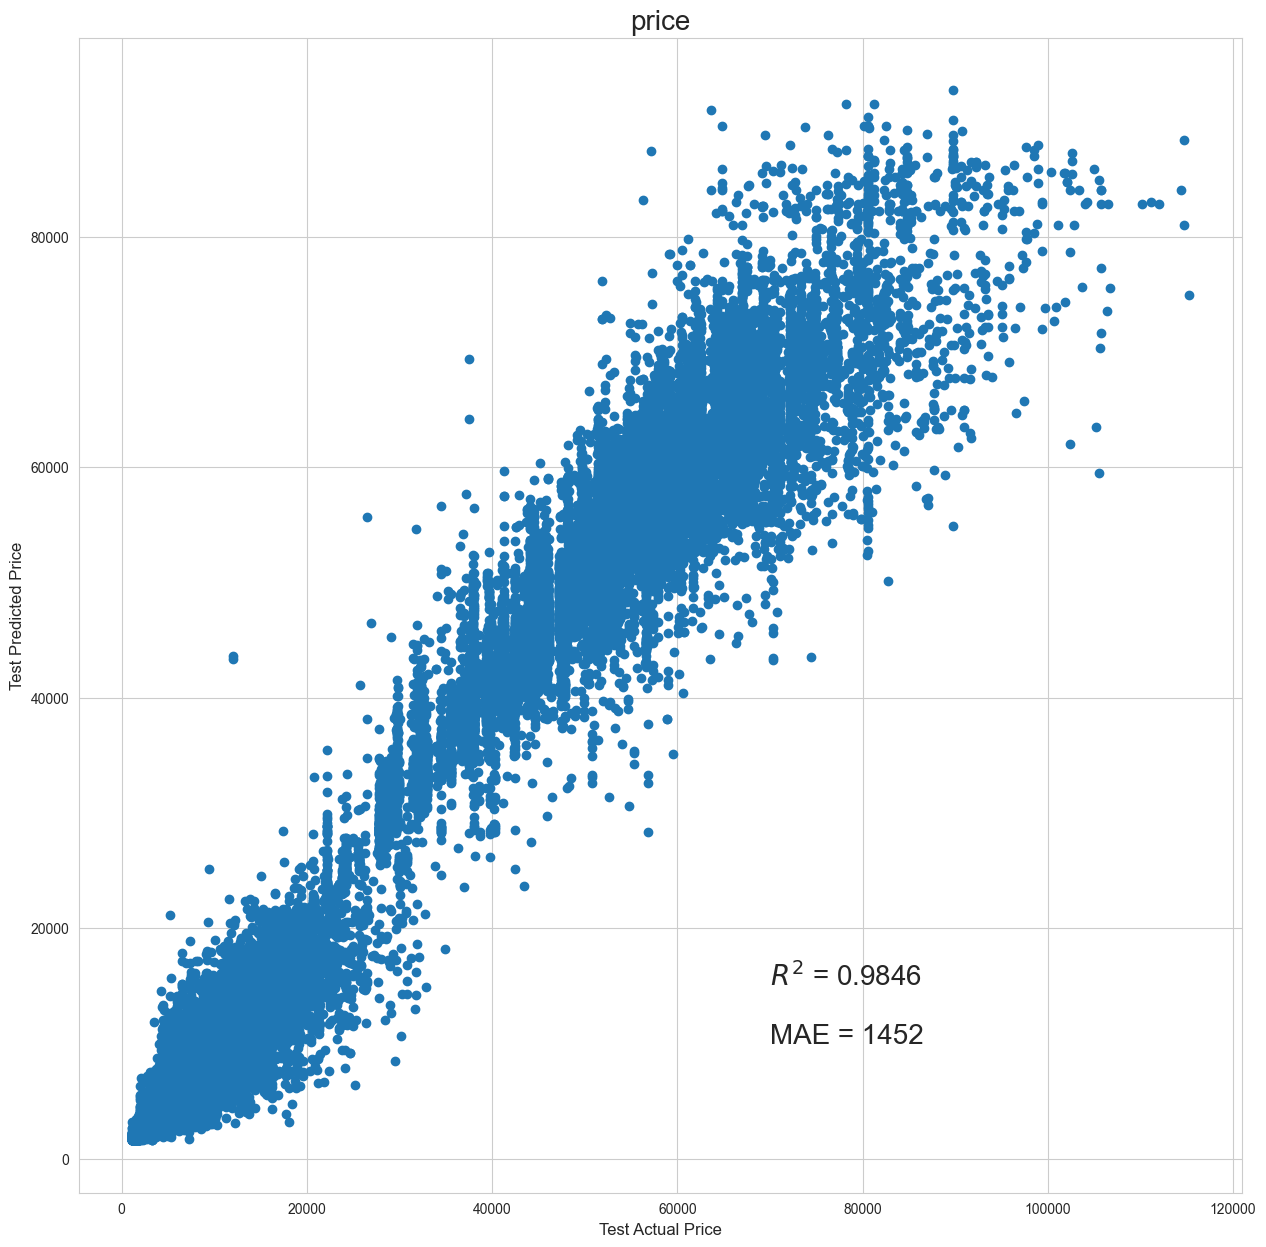

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

def plot_predictions_vs_actual(y_actual, y_predicted, title, x_label, y_label):
    # Calculate metrics
    r2 = r2_score(y_actual, y_predicted)
    mae = mean_absolute_error(y_actual, y_predicted)

    # Create plot
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(y_actual, y_predicted)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)

    # Display metrics on the plot
    plt.text(70000, 15000, f'$ R^2 $ = {round(r2, 4)}', fontsize=20)
    plt.text(70000, 10000, f'MAE = {round(mae)}', fontsize=20)
    plt.show()

# Example usage
plot_predictions_vs_actual(ytest, predictions, "price", "Test Actual Price", "Test Predicted Price")

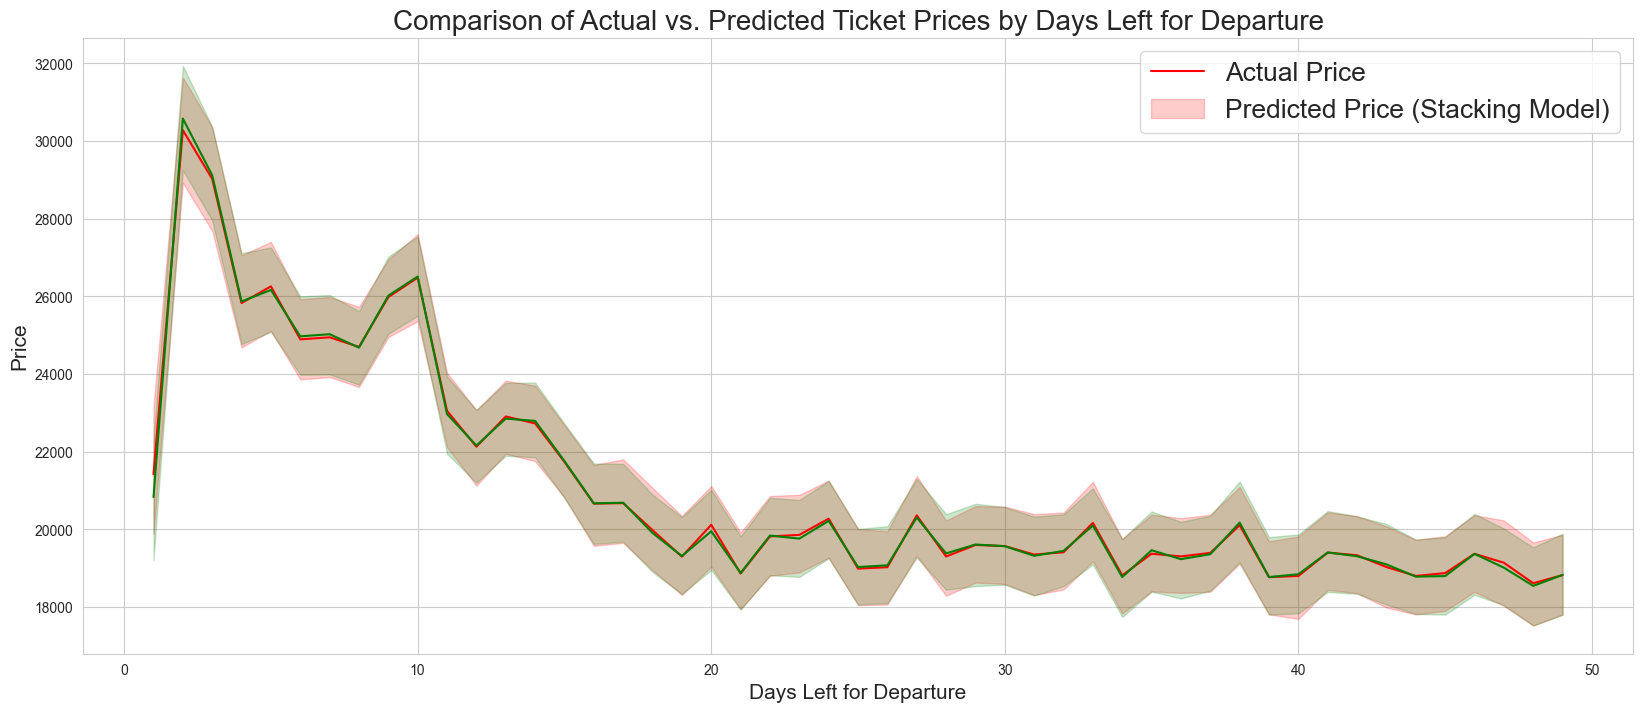

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
actual_price_plot = sns.lineplot(x=xtest['days_left'], y=ytest, color='red')
predicted_price_plot = sns.lineplot(x=xtest['days_left'], y=predictions, color='green')

plt.title('Comparison of Actual vs. Predicted Ticket Prices by Days Left for Departure', fontsize=20)
plt.legend(labels=['Actual Price', 'Predicted Price (Stacking Model)'], fontsize=19)
plt.xlabel('Days Left for Departure', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.show()
